<a href="https://colab.research.google.com/github/serereuk-tf/Tensorflow-Example/blob/main/Day1%20TF%20record%20%EB%A7%8C%EB%93%A4%EA%B8%B0/TF_Records_and_Data_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF2 데이터셋 끝내기

In [ ]:
import os
import numpy as np
import tensorflow as tf

# CIFAR100 png Version Download

원래 CIFAR100 데이터셋은 pickle 형태로 저장되어서 실생활의 예제와 다름.   
더 실생활에 적합한 학습을 위해서 이번엔 png 형태로 변환해서 진행해보려고 함.  
Torch의 ImageFolder와 같은 비슷한 폴더 형태로 되어 있을 때 연습용 

In [ ]:
## Thanks to https://github.com/knjcode/cifar2png
!pip -qq install cifar2png

In [ ]:
!cifar2png cifar100 '/content/cifar100'

cifar-100-python.tar.gz does not exists.
165kKB [00:11, 14.9kKB/s]              
Saving train images: 100% 50000/50000 [00:19<00:00, 2544.63it/s]
Saving test images: 100% 10000/10000 [00:03<00:00, 2585.66it/s]


데이터 구성은 다음과 같음
* train  
    * apple
    * aquarium_fish
    * ...
* test 
    * apple
    * aquarium_fish
    * ...

# 공식 홈페이지에 있는 코드
* _bytes_feature : 주로 이미지나 string을 저장하는데 사용. 
* _float_feature : float값을 저장하는데 사용. 
* _int64_feature : 주로 int값을 저장하는데 사용


In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 이미 구현된 좋은 클래스를 조금 수정해보자!

https://github.com/PacktPublishing/What-s-New-in-TensorFlow-2.0/blob/master/Chapter03/images/create_tfrecords_from_images.py

In [ ]:
""" Create tfrecords for image data"""
import sys
import os
import glob
import shutil
import argparse
from tqdm import tqdm


class ImageTFRecordsCreator(object):
  """ Class """
  def __init__(self, input_folder, num_shards = 1000, PRINT=False):
    """ Constructor
      Args:
      input_folder (path) : Image Folder (라벨이 각 폴더명으로 분리 되어 있을 경우)
      num_shards (int): number of sharded tfrecord
    """
    self.input_folder = input_folder 
    self.num_shards = num_shards
    self.PRINT = PRINT
    file_temp = [os.path.join(input_folder +'/train/' + path) 
                for path in os.listdir(input_folder +'/train/')]
    ## Folder Check ##
    file_temp = [i for i in file_temp
                 if os.path.isdir(i) and '.ipynb' not in i]
    self.target_to_idx = {j:i for i, j in enumerate(
                              [k.split('/')[-1] for k in file_temp])}
    if self.PRINT:
        print('# of labels : {}'.format(len(self.target_to_idx)))


  def _int64_feature(self, value):
    """Returns an int64_list from a bool / enum / int / uint."""
    if not isinstance(value, list):
      value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


  def _bytes_feature(self, value):
    """Returns a bytes_list from a string / byte."""
    if not isinstance(value, list):
      value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


  # Read image file
  def _read_image_file(self, filename):
    """
    """
    # Read the image file.
    with tf.io.gfile.GFile(filename, 'rb') as f:
      image = f.read()
    d_file = os.path.basename(filename)
    label = self.target_to_idx[filename.split('/')[-2]]
    return image, label


  # Convert sharded data to tfrecord
  def _convert_shard_data_to_tfrecord(self, input_files, output_file):
    """ Convert sharded input files to tfrecords
    """
    with tf.io.TFRecordWriter(output_file) as record_writer:
      for input_file in input_files:
        data, label = self._read_image_file(input_file)
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': self._bytes_feature(tf.compat.as_bytes(data)),
                'label': self._int64_feature(label)
            }))
        record_writer.write(example.SerializeToString())


  # Convert data to tfrecord
  def _convert_data_to_tfrecord(self, input_files, output_dir):
    """ convert input image files to tfrecords
      Args:
        input_files (list): List of input images to be converted to tfr
        output_dir (str): Output folder where created tfr files will be kept
      Description:
        Shard input_files if they are above threshold and create those many tfr
    """
    num_input_files = len(input_files)
    for i in tqdm(range(0, num_input_files, self.num_shards)):
      sharded_input_files = input_files[i:i+self.num_shards]
      tfr_file_name = os.path.join(output_dir, 'tfr_'+str(i))
      self._convert_shard_data_to_tfrecord(sharded_input_files, tfr_file_name)


  # Get file names for train, validate and test
  def _get_file_names(self, input_folder):
    """ Get file names for train, test and validation
    """
    # Get all the training files
    train_file_names = glob.glob(input_folder+'/train/*/*.png')
    validation_file_names = glob.glob(input_folder+'/validate/*/*.png')
    test_file_names = glob.glob(input_folder+'/test/*/*.png')

    file_names = {}
    file_names['train'] = train_file_names
    file_names['eval'] = validation_file_names
    file_names['test'] = test_file_names
    if self.PRINT:
        print('train : {} val : {} test : {}'.format(len(train_file_names),
                                                     len(validation_file_names),
                                                     len(test_file_names)))
    return file_names


  def create_tfrecords(self, input_folder, tfrecords_outdir):
    """ function to generate tfrecords
    Creates three sub-folders, train, eval, test and put resp 
    tfr files
    """
    raw_files = self._get_file_names(input_folder)
    for dataset_type in ['train', 'eval', 'test']:
      input_files = [fl for fl in raw_files[dataset_type]]
      dataset_resp_dir = os.path.join(tfrecords_outdir, dataset_type)
      shutil.rmtree(dataset_resp_dir, ignore_errors=True)
      os.makedirs(dataset_resp_dir)
      self._convert_data_to_tfrecord(input_files, dataset_resp_dir)






# TF Records 만들기

In [ ]:
input_folder = 'cifar100'
tfrecords_outdir = 'tfrecord_cifar100'
num_shards = 1000
tfr_creator = ImageTFRecordsCreator(input_folder, num_shards, True)
tfr_creator.create_tfrecords(input_folder, tfrecords_outdir)

  0%|          | 0/50 [00:00<?, ?it/s]

# of labels : 100
train : 50000 val : 0 test : 10000


100%|██████████| 50/50 [00:09<00:00,  5.38it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


# 만든 친구 읽어보기

In [ ]:
train_dataset = tf.data.TFRecordDataset(glob.glob('tfrecord_cifar100/train/tfr_*'))

In [ ]:
for raw_record in train_dataset.take(5):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xba\x10\n\xa7\x10\n\x05image\x12\x9d\x10\n\x9a\x10\n\x97\x10\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00 \x00\x00\x00 \x08\x02\x00\x00\x00\xfc\x18\xed\xa3\x00\x00\x07\xdeIDATx\x9cm\x96\xcbs\xdc\xc6\x11\xc6\xbb{f\xf0\xd8\xc5>H\x8a\x14E\x8a")\xeb\x11;.\'\x95r\xa5rHU\x0e9\xe7\xcf\xcd9\x87\xdc\x92\x8b\xa3\xa4,\xdb\x91m\xc9\xb2l>v\x97\xbb\x0b,\x80\x99\xe9\xe9\xceaI)\xa9\xca\x05@7\xa6~\xdf\xd7\x8d\x03>|\xf1\xc57\nJD\x88\n\x00\x88\x08\x00\x00z{\x07\x00@\x00UUUP\xd5\xed[Ux\xdf\xdc>\x88\xa8\x80\x88\x88\x88\xaa\x8a\x88\xa4$\x00jE\x19\x00TE\x15\x10A\xf5\xbd\xc0\x07\x85\xf7\xb0;\x81\xff\xa3 *wG\xe4\xae\xaf\xaaj\x89pk\xfc\x0e\x88p;\xca\x07\xd0\x87\x99>TwW\x05UEP\x02\x10\x00\x04 B\x11E\x04D@DK\x84\xaa\xb75\x00l\x17\x05\x80\x80\xb7\xdb\x81\xff\xc2~\x10\xfb\xdf\xe6m-\x80\xef\x9d\xc1\xd6\'X\x02UT\xc4\xf7\xcc-\x1f\x01TA\x01\x05\x14@\ta\xcbP\xbd3\x8f\x00\n\x8a\x00\x80\xacJ\x02*\x94P\\Jk\x15\x024\x89;\x96\xde\x02\xe2\xed\xb1\x0f\xf4\x04\xa8\n\xa8\xa2d\x04\

In [ ]:
def _parse_function(serialized_item):
    parsed_ = tf.io.parse_example(
        serialized=serialized_item,
        features={
            "image": tf.io.FixedLenFeature([], dtype=tf.string),
            "label": tf.io.FixedLenFeature([], dtype=tf.int64)
        }
    )
    return parsed_

In [ ]:
train_dataset = train_dataset.map(_parse_function)

In [ ]:
for parsed_record in train_dataset.take(1):
  image_raw = parsed_record['image'].numpy()
  label = parsed_record['label'].numpy()

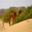

In [ ]:
import IPython.display as display
display.display(display.Image(data=image_raw))

In [ ]:
sss = {j:i for i,j in tfr_creator.target_to_idx.items()} 
sss[label]

'camel'